## 0. Overview

**Main points:**
1. We were given two files with the 2019 registered accidents in Lisbon;
2. Since both of the files have different information, we have to decide which data to use and how to normalize it;
3. We need to explore the data to decide wich data to keep.

This notebook has the main objective of preparing the accident data for further evaluation. To clean the data we first need to perform basic exploration of the data and understand what needs to be done. 

## 1. Import the required modules

First we import the necessary modules.

In [1]:
import pandas as pd
import numpy as np
import json
from haversine import haversine_vector, Unit
import ast
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Load accident data

**`First file`**

1. This file has multiple sheets, so we will import each of the sheets to a different data frame.

In [2]:
first_file_path = '../00-data/raw/Acidentes_ANSR_2019_desafio_lxdatalab_2020_21.xlsx'
accidents_first_file = pd.read_excel(first_file_path, sheet_name='acidentes')
vehicle_first_file = pd.read_excel(first_file_path, sheet_name='veíc-cond')
passangers_first_file = pd.read_excel(first_file_path, sheet_name='passageiros')
pedestrians_first_file = pd.read_excel(first_file_path, sheet_name='peões')

**`Second file`**
1. Second file is more simple and has less information.

In [3]:
second_file_path = '../00-data/raw/RSB_AcidentesRodoviarios2019.csv'
accidents_second_file = pd.read_csv(second_file_path, sep=';', encoding='cp1252')

## 3. Data exploration

In this chapter we perform basic data exploration using diferent methods. We try to evaluate the data and verify its quality (errors, outliers available data using basic and graphical tools.

### 3.1. Accidents first file

First we evaluate the first file of accidents.

**`Data shape`**

In [4]:
accidents_first_file.shape

(2768, 37)

We have information of almost 3000 accidents.

**`Data overview`**

In [5]:
accidents_first_file.head().T

,0,1,2,3,4
IdAcidente,20191648491,20191648498,20191648520,20191649633,20191649654
Datahora,2019:01:02 15:10:00,2019:01:02 16:45:00,2019:01:02 13:05:00,2019:01:03 09:20:00,2019:01:03 18:15:00
Dia da Semana,Quarta-Feira,Quarta-Feira,Quarta-Feira,Quinta-Feira,Quinta-Feira
Sentidos,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO,NÃO DEFINIDO
Latitude GPS,38.768367,38.719096,38.728779,38.793481,NaN
Longitude GPS,-9.172899,-9.15613,-9.147518,-9.151816,NaN
Via Trânsito,Direita,Esquerda,Central,Direita,Direita
Localizações,Dentro das localidades,Dentro das localidades,Dentro das localidades,Dentro das localidades,Dentro das localidades
Freguesia,Lumiar,Campo de Ourique,Avenidas Novas,Santa Clara,Santo António
Pov. Proxima,Lisboa,Lisboa,Lisboa,NaN,NaN


Main points:
* For this case we have a rich set of information, however, it is difficult to understand the meaning of some of the reatures. Namelly, VM, FG, FL whch will need to be further evaluated;
* Some of the locations don't have geolocation, which might be a problem and needs to be evaluated;
* We have information of the type of accidents which may help identification of different root casuses for different types of accidents;
* We have a lot of information regarding the conditions and location of the accidents.

**`Missing values`**

In [6]:
accidents_first_file.isna().sum()

IdAcidente                     0
Datahora                       0
Dia da Semana                  0
Sentidos                       0
Latitude GPS                 945
Longitude GPS                945
Via Trânsito                   0
Localizações                   0
Freguesia                      0
Pov. Proxima                1322
Tipo Natureza                  0
Natureza                       0
Traçado 1                      0
Traçado 2                      0
Traçado 3                      0
Traçado 4                      0
Estado Conservação             0
Características Tecnicas       0
Reg Circulação                 0
Marca Via                      0
Obstáculos                     0
Sinais                         0
Sinais Luminosos               0
Tipo Piso                      0
Intersecção Vias               0
Factores Atmosféricos          0
Luminosidade                   0
Cond Aderência                 0
VM                             0
FG                             0
FL        

Main points:
* We have some missing values. Most are are non critical.
* However, the missing values of latitude and longitude may represent a major probem when performing geolocation evaluations.

**`Statistical evaluation`**

In [7]:
accidents_first_file.describe()

,IdAcidente,Latitude GPS,Longitude GPS,VM,FG,FL,Km
count,2.768000e+03,1823.000000,1823.000000,2768.000000,2768.000000,2768.000000,249.000000
mean,2.019191e+10,38.733288,-9.150429,0.002890,0.024205,1.177384,4.058783
std,1.372972e+06,0.063683,0.062830,0.053692,0.160612,0.607121,3.264365
min,2.019165e+10,37.017289,-9.413910,0.000000,0.000000,0.000000,0.000000
25%,2.019167e+10,38.718220,-9.170539,0.000000,0.000000,1.000000,1.500000
50%,2.019172e+10,38.734634,-9.150388,0.000000,0.000000,1.000000,3.135000
75%,2.019177e+10,38.751966,-9.135339,0.000000,0.000000,1.000000,6.200000
max,2.020187e+10,38.918566,-7.413290,1.000000,2.000000,9.000000,18.000000


Main points:
* IdAccidente should be converted to index;
* Latitude seems to present some outliers. A value with a latitude of 37 seem a bit off and needs to be evaluated;
* Same with longitude which presents a value of -7.4 that seems to be far away from Lisbon.

In [8]:
accidents_first_file.describe(include='O').T

,count,unique,top,freq
Datahora,2768,2708,2019:09:28 12:15:00,3
Dia da Semana,2768,7,Sexta-Feira,478
Sentidos,2768,3,NÃO DEFINIDO,1852
Via Trânsito,2768,3,Direita,2025
Localizações,2768,2,Dentro das localidades,2596
Freguesia,2768,24,Avenidas Novas,244
Pov. Proxima,1446,16,Lisboa,1390
Tipo Natureza,2768,3,Colisão,1573
Natureza,2768,17,Atropelamento de peões,640
Traçado 1,2768,3,Recta,2327


Main points:
* Has expected we have a lot of descriptive data;
* Most of these features need to be further evalauted;
* Some of the variables present a high cardinality;

**`Outliers evaluation`**

In [9]:
accidents_first_file.skew()

IdAcidente        7.077352
Latitude GPS    -20.883582
Longitude GPS    18.338325
VM               18.530381
FG                6.963867
FL                4.002868
Km                0.815360
dtype: float64

Main points:
* As expected Latitude and longitude have some outliers;
* Let's evaluate them better.

<AxesSubplot:xlabel='Longitude GPS'>

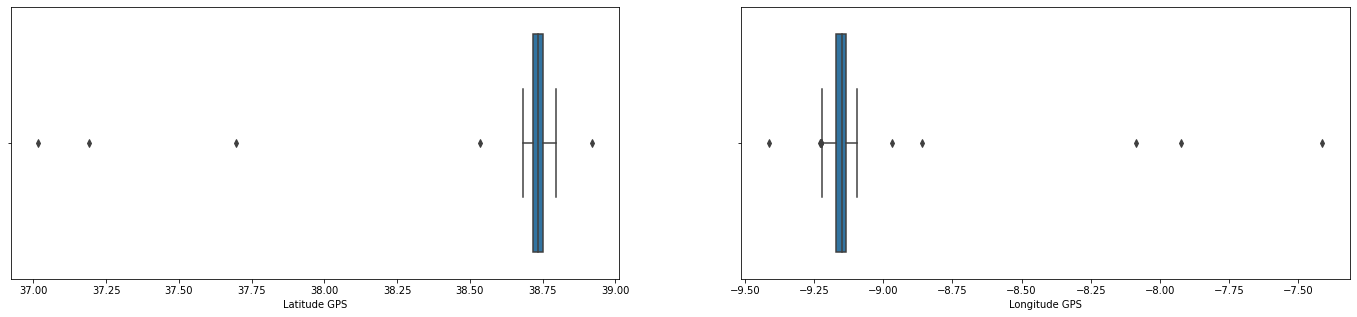

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(data = accidents_first_file, x = 'Latitude GPS', ax = axes[0])
sns.boxplot(data = accidents_first_file, x = 'Longitude GPS', ax = axes[1])

Main points:
* We can also see this when we do a boxplot, latitude and longitude have a lot of outliers;

<AxesSubplot:xlabel='Longitude GPS', ylabel='Latitude GPS'>

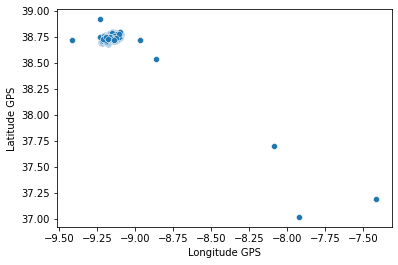

In [11]:
sns.scatterplot(data = accidents_first_file, y = 'Latitude GPS', x = 'Longitude GPS')

Main points:
* Since this is Lisbon we should be able see the city in the data, but it seems that the outliers are really big;
* Lets try to remove some and reavaluate;

**`Removing outliers evaluation`**

In [35]:
accidents_first_file_no_outliers = (
    accidents_first_file
    .loc[lambda x: x['Latitude GPS'] > 38.55]
    .loc[lambda x: x['Latitude GPS'] < 38.80]
    .loc[lambda x: x['Longitude GPS'] > -9.30]
    .loc[lambda x: x['Longitude GPS'] < -9.00]
)

<AxesSubplot:xlabel='Longitude GPS'>

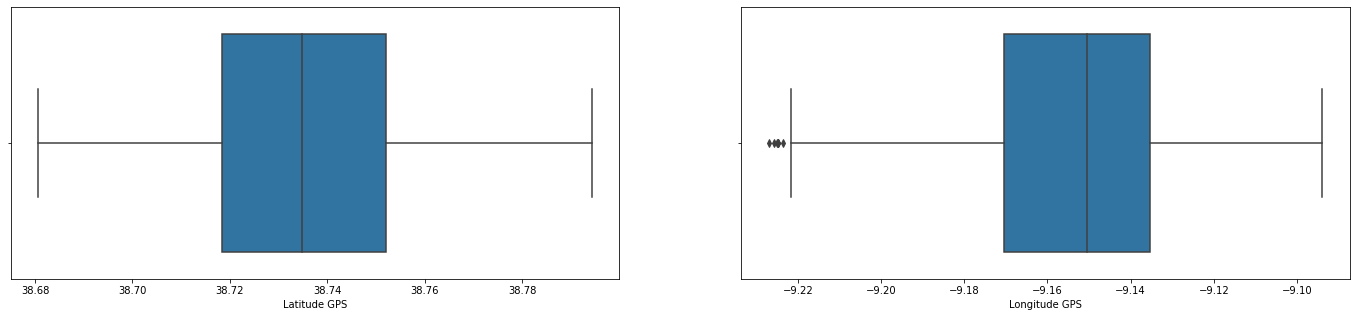

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(24, 5))
sns.boxplot(data = accidents_first_file_no_outliers, x = 'Latitude GPS', ax = axes[0])
sns.boxplot(data = accidents_first_file_no_outliers, x = 'Longitude GPS', ax = axes[1])

<AxesSubplot:xlabel='Longitude GPS', ylabel='Latitude GPS'>

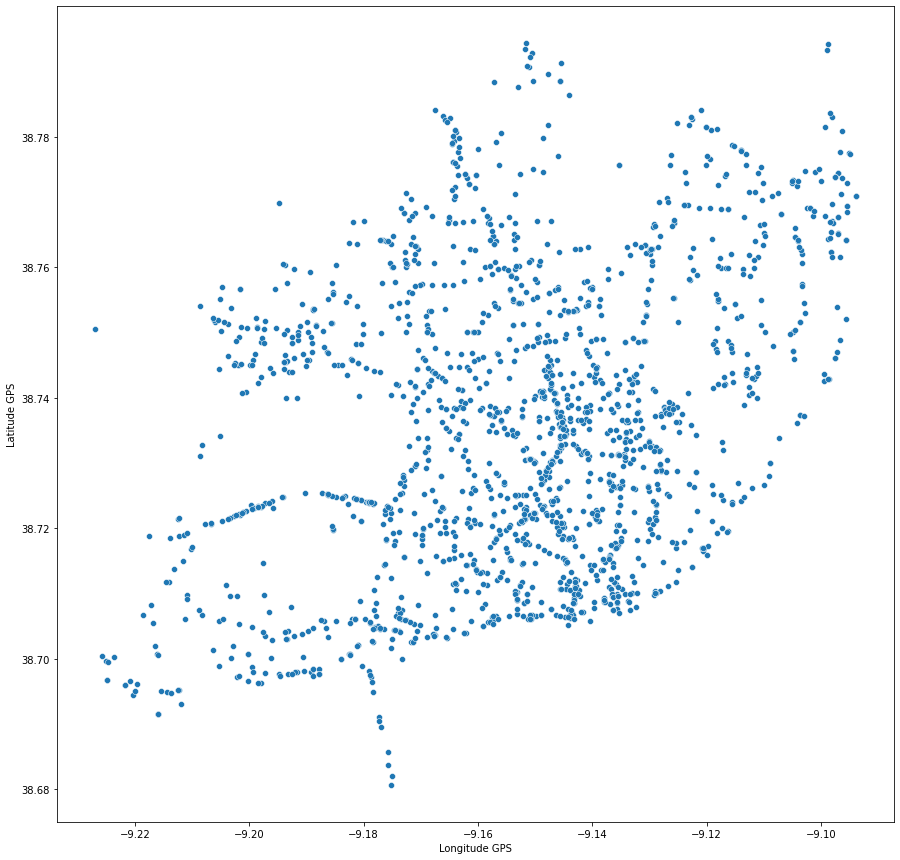

In [38]:
plt.figure(figsize = (15, 15))
sns.scatterplot(data = accidents_first_file_no_outliers, y = 'Latitude GPS', x = 'Longitude GPS')

Main points:
* Now we can see more less Lisbon and so the data makes more sense

In [ ]:
sns.scatterplot(data = accidents_first_file, x=latitude)

**`Accident type evaluation`**

In [10]:
accidents_first_file['Tipo Natureza'].value_counts(normalize=True).round(2)

Colisão          0.57
Atropelamento    0.24
Despiste         0.19
Name: Tipo Natureza, dtype: float64

Main points:
* Most of the accidents are colision accidents;
* However, run over accidents also have a high incident rate and probably have different caracteristics that should be evaluated.

**`Duplicated accidents`**

In [11]:
accidents_first_file['IdAcidente'].duplicated().sum()

0

Main points:
* No duplicated values;

### 3.2. Accidents second file

**`Data shape`**

In [12]:
accidents_second_file.shape

(1817, 7)

**`Data overview`**

In [13]:
accidents_second_file.head().T

,0,1,2,3,4
code,42111/O/2019 %ob%367804042019%cb%,60907/O/2019%ob%1161715092019%cb%,51303/O/2019 %ob%466825042019%cb%,60191/O/2019%ob%1094106092019%cb%,51894/O/2019 %ob%525207052019%cb%
position,"{'coordinates': [-9.14692611215691, 38.7303459...","{'coordinates': [-9.15795701650941, 38.7128447...","{'coordinates': [-9.10134876304967, 38.7442906...","{'coordinates': [-9.17515018021679, 38.7121700...","{'coordinates': [-9.13078619741982, 38.7282074..."
freguesia,Avenidas Novas,Estrela,Marvila,Campo de Ourique,Penha de França
tipologia,2102 - Acidentes - Rodoviários - Com viaturas,2102 - Acidentes - Rodoviários - Com viaturas,2102 - Acidentes - Rodoviários - Com viaturas,2101 - Acidentes - Rodoviários - Atropelamento,2101 - Acidentes - Rodoviários - Atropelamento
dtregisto,04/04/2019 02:13,15/09/2019 00:28,25/04/2019 00:01,06/09/2019 14:27,07/05/2019 13:11
dia_registo,04/04/2019,15/09/2019,25/04/2019,06/09/2019,07/05/2019
hora_registo,2,0,0,14,13


Main points:
* In this data set there are less features to be evaluated, so we will need to take some decisions if we want to merge the data;
* The accident types are different than the ones in the previous file, so once again we need to normalize the accident type data;
* There seems to be a feature called position that can be used directly in geo-pandas (will have to try it in the next steps).

**`Missing values`**

In [14]:
accidents_second_file.isna().sum()

code             0
position         0
freguesia       32
tipologia        0
dtregisto        0
dia_registo      0
hora_registo     0
dtype: int64

Main points:
* There seems to be some missing values. However, they don't seem to impact our analysis.

**`Statistical evaluation`**

In [15]:
accidents_second_file.describe()

,hora_registo
count,1817.000000
mean,13.433682
std,5.934493
min,0.000000
25%,9.000000
50%,14.000000
75%,18.000000
max,23.000000


Main points:
* Only the hour feature is numeric and no significant information can be taken from it.

In [16]:
accidents_second_file.describe(include='O').T

,count,unique,top,freq
code,1817,1641,62821/O/2019%ob%1347316102019%cb%,4
position,1817,1214,"{'coordinates': [-9.17295260295721, 38.7263530...",42
freguesia,1785,24,Alvalade,149
tipologia,1817,4,2102 - Acidentes - Rodoviários - Com viaturas,1455
dtregisto,1817,1618,30/11/2019 04:36,21
dia_registo,1817,326,30/11/2019,37


Main points:
* There seems to be some locations with multiple accidents (one with 42 even);
* We only seem to have 4 types of accidents, however this as to be better evaluated;
* Also, there seems to be some accidents that occurred at exactly the same date. This also has to be evaluated.

**`Accident type evaluation`**

In [17]:
accidents_second_file['tipologia'].value_counts(normalize=True).round(2)

2102 - Acidentes - Rodoviários - Com viaturas        0.80
2101 - Acidentes - Rodoviários - Atropelamento       0.10
2103 - Acidentes - Rodoviários - Com Encarcerados    0.07
2103 - Acidentes - Rodoviários - ComEncarcerados     0.03
Name: tipologia, dtype: float64

Main points:
* Most of the accidents are car accidents;
* The next one are the run over accidents.

**`Accident duplicates data evaluation`**

In [40]:
accidents_second_file.drop(columns = 'code').duplicated().sum()

20

Main points:
* There seems to be some duplicated accidents;
* Will have to a better evaluation of the duplicated values;
* Also will have to evaluate the ones that are closer and not duplicated (have the same freguesia, hora but different position that may be close togheter)

## 4. Data cleaning

Since the second file only have basic information on the accidents we opted to clean both of the files separately and then create three dataframes with different objectives:
1. Information regarding the accidents without geolocation features;
2. Information regarding the accidents with geolocation features;
3. Information from the first file with all the accidents characteristics.

### 4.1. User defined functions

In [175]:
def prepare_file_without_geolocation(df1, df2, with_geo):
    """ Prepares the first and second accident file. """
    
    # cleans both accident files
    clean_df1 = clean_accidents_first_file(df1)
    clean_df2 = clean_accidents_second_file(df2)

    # prepares the data with or without geolocation
    if with_geo:
        final_data = (
            pd.concat([clean_df1, clean_df2])
            .dropna()
        )
    else:
        final_data = (
            pd.concat([clean_df1, clean_df2])
            .drop(columns = ['latitude', 'longitude'])
        )
    return final_data

def clean_accidents_first_file(df):
    """ Cleans the first accident data file. """
    clean_df = (
        df
        [['Datahora', 'Tipo Natureza', 'Latitude GPS', 'Longitude GPS']]
        .pipe(convert_to_datetime, 'Datahora', 1)
        .pipe(rename_columns)
        .pipe(correct_accident_type, 'accident_type')
        .pipe(add_hour, 'date')
        .pipe(add_weekday, 'date')
        .pipe(add_month, 'date')
        .pipe(add_year_day, 'date')
    )
    return clean_df


def clean_accidents_second_file(df):
    """ Cleans the second accident file. """
    clean_df = (
        df
        .drop(columns = 'code')
        .drop_duplicates()
        [['position', 'tipologia', 'dtregisto']]
        .pipe(add_location, 'position')
        .pipe(rename_columns)
        .pipe(correct_accident_type, 'accident_type')
        .pipe(convert_to_datetime, 'date', 2)
        .pipe(adds_time_features, 'date')
    )
    return clean_df


def convert_to_datetime(df, date_column, version):
    """ Converts the date column to datetime"""
    df = df.copy()
    
    # uses version one or two depending of the file
    if version == 1:
        df[date_column] = pd.to_datetime(df[date_column], format='%Y:%m:%d %H:%M:%S')
    elif version == 2:
        df[date_column] = pd.to_datetime(df[date_column], format='%d/%m/%Y %H:%M')
    return df



def rename_columns(df):
    """ Renames the columns to have a uniform structure. """
    
    # rename diccionary
    rename_dict = {'Datahora': 'date',
                   'Tipo Natureza': 'accident_type',
                   'Latitude GPS': 'latitude',
                   'Longitude GPS': 'longitude',
                   'tipologia': 'accident_type',
                   'dtregisto': 'date'}
    return df.rename(columns=rename_dict)


def adds_time_features(df, date_column):
    """ Adds the time information needed. """
    df = df.copy()
    
    # creates the new columns
    df = df.assign(hour = df[date_column].dt.hour,
                   weekday = df[date_column].dt.weekday,
                   month = df[date_column].dt.month,
                   day_of_year = df[date_column].dt.day_of_year)
    return df


def add_location(df, location_column):
    """ Converts the location json from the second file to columns """
    df = df.copy()
    
    # gets the location
    location = pd.DataFrame(df
                            .position
                            .apply(lambda x: json.loads(x.replace("'", '"'))['coordinates'])
                            .to_list(), 
                            columns=['longitude', 'latitude'])
    
    # merges the location information
    df = pd.concat([df.reset_index(drop=True), 
                    location.reset_index(drop=True)], axis=1)
    
    # drops the position column
    df.drop(columns=['position'], inplace=True)
    return df


def correct_accident_type(df, accident_column):
    """ Renames the accident data to be uniform. """
    
    # rename dictionary
    rename_dict = {'2102 - Acidentes - Rodoviários - Com viaturas': 'Colisão/Despiste',
                   '2101 - Acidentes - Rodoviários - Atropelamento': 'Atropelamento',
                   '2103 - Acidentes - Rodoviários - Com Encarcerados': 'Colisão/Despiste',
                   '2103 - Acidentes - Rodoviários - ComEncarcerados': 'Colisão/Despiste',
                   'Colisão': 'Colisão/Despiste',
                   'Despiste': 'Colisão/Despiste'}
    return df.replace(rename_dict)

### 4.2. Prepare data without geolocation

In [178]:
data_wo_geolocation = prepare_file_without_geolocation(accidents_first_file, accidents_second_file, False)

In [179]:
data_wo_geolocation.to_parquet('../00-data/processed/data_wo_geolocation.parquet')

### 4.3. Prepare data with geolocation

In [182]:
data_w_geolocation = prepare_file_without_geolocation(accidents_first_file, accidents_second_file, True)

In [157]:
data_w_geolocation.to_parquet('../00-data/processed/data_w_geolocation.parquet')

### 4.4. Prepare data with the police report information